# Phân loại 5 loại hoa: hoa cúc, hoa bồ công anh, hoa hồng, hoa hướng dương, hoa tulip


In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# tắt thông báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

In [ ]:
# thực hiện các biến đổi trên hình ảnhs.
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # xoay ảnh ngẫu nhiên trong khoảng +/- 10 độ
        transforms.RandomHorizontalFlip(),  # lật ngang ngẫu nhiên 50% số ảnh
        transforms.Resize(224),             # thay đổi kích thước chiều ngắn nhất của ảnh thành 224 pixel
        transforms.CenterCrop(224),         # cắt ảnh ở trung tâm với kích thước 224x224 pixel
        transforms.ToTensor(),              # chuyển đổi ảnh thành tensor
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])# chuẩn hóa ảnh với giá trị trung bình và độ lệch chuẩn tương ứng
])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# Dataset
data_directory = '/content/drive/MyDrive/Thị giác máy tính/flowers'
dataset=datasets.ImageFolder(root=data_directory,transform=train_transform)
dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset ImageFolder
    Number of datapoints: 4318
    Root location: /content/drive/MyDrive/Thị giác máy tính/CV-project/flowers
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# Check các loại hoa
torch.manual_seed(10)
torch.cuda.manual_seed_all(10)

# Lấy danh sách các lớp hoa từ dataset và in ra
class_names=dataset.classes
print(class_names)
print(len(class_names))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
5


In [ ]:
# chia ra tập Train và tập Test
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets)
train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

In [ ]:
# chia thành các batch để huấn luyện mô hình
train_loader1=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader1=DataLoader(test_data,batch_size=10)

In [ ]:
# di chuyển dữ liệu và các batch dữ liệu tới thiết bị được chọn (GPU hoặc CPU)
def to_device(data, device):
      # Di chuyển tensor(s) tới thiết bị được chọn
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
      #  Lớp bao bọc một DataLoader để di chuyển dữ liệu tới thiết bị được chọn
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        # Trả về một batch dữ liệu sau khi đã di chuyển tới thiết bị
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        # Số lượng batch
        return len(self.dl)

train_loader = DeviceDataLoader(train_loader1, device)
test_loader = DeviceDataLoader(test_loader1, device)

In [ ]:
# in ra số lượng mẫu
print(len(train_data))
print(len(test_data))

3454
864


In [ ]:
# Xem trước tập dữ liệu.
for images, labels in train_loader:
    break
#In ra nhãn của batch đầu tiên
print('Label:', labels.cpu().numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

# Tạo lưới hình ảnh từ batch đầu tiên
im=make_grid(images,nrow=5)

Label: [0 3 3 0 0 3 2 0 1 4]
Class: daisy sunflower sunflower daisy daisy sunflower rose daisy dandelion tulip


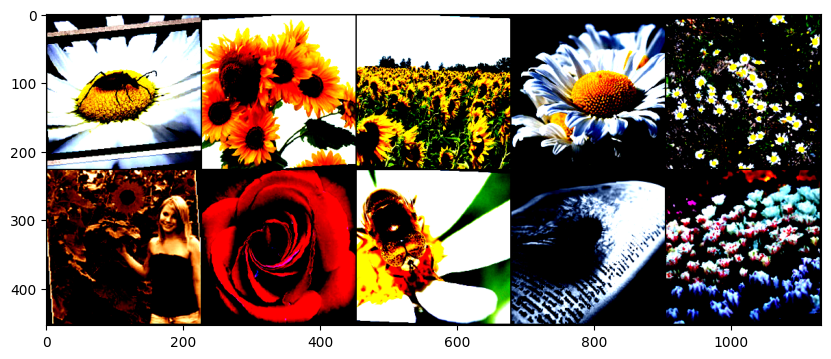

In [ ]:
plt.figure(figsize=(10,10))# Cài đặt kích thước của hình vẽ
# Chuyển đổi tensor về numpy array và chuyển đổi chiều cho phù hợp với Matplotlib (CHW -> HWC) và in ra
plt.imshow(np.transpose(im.cpu().numpy(),(1,2,0)))

In [ ]:
# đảo ngược quá trình chuẩn hóa
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                     std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

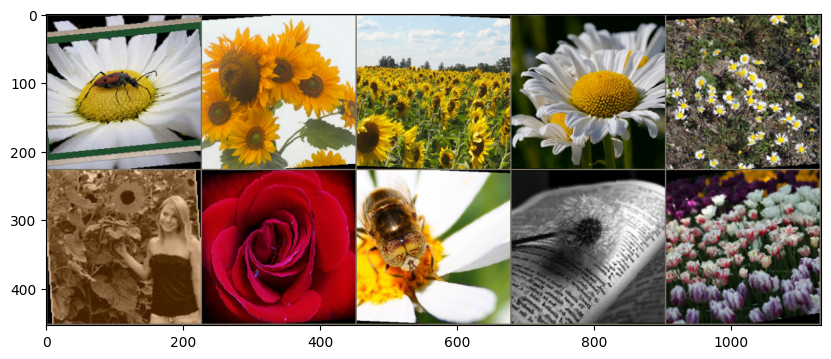

In [ ]:
plt.figure(figsize=(10,10))# Cài đặt kích thước của hình vẽ
plt.imshow(np.transpose(im.cpu().numpy(),(1,2,0)))

#CNN

In [ ]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,3,1)#Convolutional layer 1 với đầu vào 3 kênh (ảnh RGB), đầu ra 6 kênh, kernel size 3x3 và stride 1.
        self.conv2=nn.Conv2d(6,16,3,1)#Convolutional layer 2 với đầu vào 6 kênh (từ convolution trước), đầu ra 16 kênh, kernel size 3x3 và stride 1.
        self.fc1=nn.Linear(16*54*54,120)#Fully connected layer 1
        self.fc2=nn.Linear(120,84)#Fully connected layer 2
        self.fc3=nn.Linear(84,20)#Fully connected layer 3
        self.fc4=nn.Linear(20,5)#Fully connected layer 4

    def forward(self,X):
        X=F.relu(self.conv1(X))#Áp dụng convolution và sau đó là hàm kích hoạt ReLU.
        X=F.max_pool2d(X,2,2)#Áp dụng max pooling với kernel size 2x2 và stride 2.
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,16*54*54)#Flatten các feature map thành một vector để đưa vào fully connected layers.
        X=F.relu(self.fc1(X))#Fully connected layer 1 với ReLU.
        X=F.relu(self.fc2(X))
        X=F.relu(self.fc3(X))
        X=self.fc4(X)#Fully connected layer cuối cùng không có hàm kích hoạt, là đầu ra của mạng.

        # Áp dụng hàm softmax lên output để có được xác suất của từng lớp, và sau đó lấy logarit để tính toán mất mát Cross Entropy.
        return F.log_softmax(X, dim=1)#


CNNmodel=ConvolutionalNetwork().to(device)
criterion=nn.CrossEntropyLoss()#Định nghĩa hàm mất mát là Cross Entropy Loss
#Chọn thuật toán tối ưu hóa là Adam để cập nhật các tham số của mô hình với learning rate là 0.001.
optimizer=torch.optim.Adam(CNNmodel.parameters(),lr=0.001)


In [ ]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
# đếm và in ra số lượng tham số có thể huấn luyện trong mô hình
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
    1680
      20
     100
       5
________
 5611857


In [ ]:
# Learning Schema.
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
epochs=25

# Vòng lặp chính huấn luyện mô hình
for i in range(epochs):
    trn_corr=0
    tst_corr=0
    # Lặp qua từng batch dữ liệu trong tập huấn luyện (train_loader)
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred=CNNmodel(X_train) # Dự đoán đầu ra
        loss=criterion(y_pred,y_train)# Tính toán hàm mất mát (loss)

        predicted=torch.max(y_pred.data,1)[1]# Lấy chỉ số lớp dự đoán có xác suất cao nhất
        batch_corr=(predicted==y_train).sum()# Đếm số lượng dự đoán chính xác trong batch hiện tại
        trn_corr+=batch_corr# Cộng dồn số lượng dự đoán chính xác vào biến trn_corr

        optimizer.zero_grad() #Đặt gradient về 0
        loss.backward()# Tính toán gradient của các tham số mô hình
        optimizer.step()# Cập nhật các tham số của mô hình dựa trên gradient đã tính được


    loss=loss.detach().cpu().numpy()
    trn_corr=trn_corr.cpu().numpy()# Chuyển đổi trn_corr về numpy array
    trn_corr=trn_corr*100/3453# Tính tỷ lệ dự đoán chính xác trên toàn bộ tập huấn luyện
    train_losses.append(loss)# Thêm giá trị loss vào danh sách train_losses
    train_correct.append(trn_corr) # Thêm tỷ lệ dự đoán chính xác vào danh sách train_correct

# Kiểm tra độ chính xác của mô hình trên tập kiểm tra
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1
            y_val=CNNmodel(X_test)# Dự đoán đầu ra
            loss=criterion(y_val,y_test)# Tính toán hàm mất mát trên tập test

            predicted=torch.max(y_val.data,1)[1]# Lấy chỉ số lớp dự đoán có xác suất cao nhất
            btach_corr=(predicted==y_test).sum()# Đếm số lượng dự đoán chính xác trong batch test
            tst_corr+=btach_corr# Cộng dồn số lượng dự đoán chính xác vào biến tst_corr


 # In ra thông tin về quá trình test
        print(f"test: epoch: {i} loss: {loss.item():4f} batch: {b} accuracy: {tst_corr.item()*100/(10*b):7.3f}%")
        loss=loss.detach().cpu().numpy()
        tst_corr=tst_corr.cpu().numpy()
        tst_corr=tst_corr*100/864 # Tính tỷ lệ dự đoán chính xác trên toàn bộ tập test
        test_losses.append(loss)
        test_correct.append(tst_corr)

# In ra tổng thời gian huấn luyện mô hình
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

# Lưu mô hình vào ổ đĩa
torch.save(CNNmodel.state_dict(), '/content/drive/MyDrive/Thị giác máy tính/CV-project/model/CNNmodel.pth')
print('Model đã được lưu lại thành công vào file CNNmodel.pth')

test: epoch: 0 loss: 1.186490 batch: 87 accuracy:  51.264%
test: epoch: 1 loss: 1.616101 batch: 87 accuracy:  57.241%
test: epoch: 2 loss: 1.598483 batch: 87 accuracy:  60.805%
test: epoch: 3 loss: 1.258724 batch: 87 accuracy:  63.333%
test: epoch: 4 loss: 1.629929 batch: 87 accuracy:  65.862%
test: epoch: 5 loss: 2.640479 batch: 87 accuracy:  62.874%
test: epoch: 6 loss: 1.827274 batch: 87 accuracy:  66.437%
test: epoch: 7 loss: 1.904264 batch: 87 accuracy:  66.322%
test: epoch: 8 loss: 1.965727 batch: 87 accuracy:  66.897%
test: epoch: 9 loss: 2.567682 batch: 87 accuracy:  68.161%
test: epoch: 10 loss: 2.116978 batch: 87 accuracy:  68.046%
test: epoch: 11 loss: 2.556547 batch: 87 accuracy:  65.287%
test: epoch: 12 loss: 3.368453 batch: 87 accuracy:  65.747%
test: epoch: 13 loss: 2.922573 batch: 87 accuracy:  68.276%
test: epoch: 14 loss: 2.529261 batch: 87 accuracy:  67.816%
test: epoch: 15 loss: 3.346819 batch: 87 accuracy:  66.782%
test: epoch: 16 loss: 2.524963 batch: 87 accuracy:

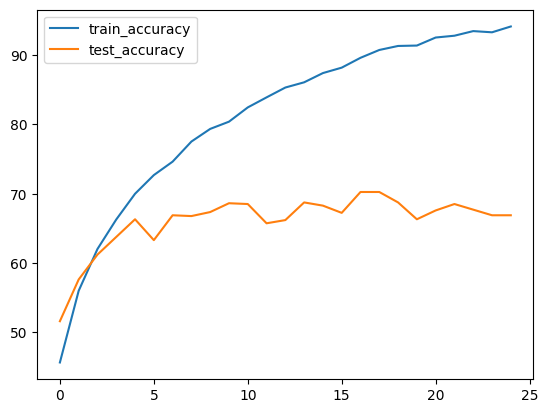

In [ ]:
# Vẽ biểu đồ độ chính xác(accuracy)
plt.plot(train_correct,label="train_accuracy")
plt.plot(test_correct,label="test_accuracy")
plt.legend()

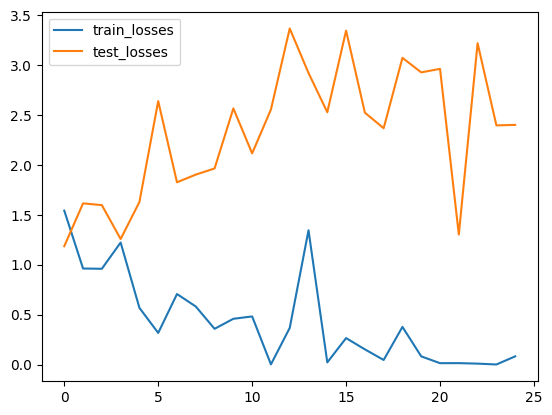

In [ ]:
#  Vẽ đồ thị biểu diễn sự thay đổi của hàm mất mát
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()



#Resnet18

In [ ]:
#resnet18

#Lớp này định nghĩa một khối cơ bản
class BasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride):
        super(BasicBlock,self).__init__()
        #Lớp convolution đầu tiên
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding=1)
        # Lớp batch normalization cho conv1
        self.bn1=nn.BatchNorm2d(out_channels)

        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size,stride,padding=1)
        self.bn2=nn.BatchNorm2d(out_channels)

    def forward(self,x):
      # Thực hiện conv1 và batch normalization
        output=self.bn1(self.conv1(x))
        output=self.bn2(self.conv2(output))
        # Trả về kết quả sau khi áp dụng hàm ReLU cho tổng của input ban đầu và output
        return F.relu(x+output)

# Lớp này định nghĩa một khối đặc biệt để giảm kích thước của feature map
class BasicDownBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride):
        super(BasicDownBlock,self).__init__()
        # Lớp convolution đầu tiên với kernel size và stride đầu tiên
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size[0],stride[0],padding=1)
        # Lớp batch normalization cho conv1
        self.bn1=nn.BatchNorm2d(out_channels)
        # Lớp convolution thứ hai với kernel size và stride thứ hai
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size[0],stride[1],padding=1)
        # Lớp batch normalization cho conv2
        self.bn2=nn.BatchNorm2d(out_channels)
        # Lớp convolution thứ ba để thay đổi kích thước đầu vào
        self.conv3=nn.Conv2d(in_channels,out_channels,kernel_size[1],stride[0])
        # Lớp batch normalization cho conv3
        self.bn3=nn.BatchNorm2d(out_channels)

    def forward(self,x):
      # Thực hiện conv1 và batch normalization
        output=self.bn1(self.conv1(x))
        # Thực hiện conv2 và batch normalization
        output=self.bn2(self.conv2(output))
         # Thực hiện conv3 và batch normalization cho đầu vào
        output1=self.bn3(self.conv3(x))
          # Trả về kết quả sau khi áp dụng hàm ReLU cho tổng của output1 và output
        return F.relu(output1+output)

class Resnet18(nn.Module):
    def __init__(self):
        super().__init__()
        # 3x224x224-->64x112x112
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3)
        self.bn1=nn.BatchNorm2d(64)
        # 64x112x112-->64x56x56
        self.pool1=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        #Lớp residual block đầu tiên: 64x56x56-->64x56x56
        self.layer1=nn.Sequential(
            BasicBlock(64,64,3,1),
            BasicBlock(64,64,3,1)
        )
        # 64x56x56-->128*28*28
        self.layer2=nn.Sequential(
            BasicDownBlock(64,128,[3,1],[2,1]),
            BasicBlock(128,128,3,1)
        )
        # 128*28*28-->256*14*14
        self.layer3=nn.Sequential(
            BasicDownBlock(128,256,[3,1],[2,1]),
            BasicBlock(256,256,3,1)
        )
        # 256*14*14-->512x7x7
        self.layer4=nn.Sequential(
            BasicDownBlock(256,512,[7,1],[2,1]),
            BasicBlock(512,512,3,1)
        )
        #Lớp Adaptive Max Pooling: 512x7x7-->512x1x1
        self.avgpool=nn.AdaptiveMaxPool2d(output_size=(1,1))
        self.flat=nn.Flatten()#Lớp Flatten để chuyển đổi từ tensor 2D sang 1D
        # Lớp fully connected: 512 --> số lớp phân loại
        self.linear=nn.Linear(512,5)# 5 là số lượng label trong bài toán phân loại

    def forward(self,x):
      # Áp dụng lớp conv1, batch normalization và ReLU
        output=self.pool1(F.relu(self.bn1(self.conv1(x))))
        # Áp dụng các residual block
        output=self.layer1(output)
        output=self.layer2(output)
        output=self.layer3(output)
        output=self.layer4(output)
        # Áp dụng lớp Adaptive Max Pooling
        output=self.avgpool(output)
        # Áp dụng lớp Flatten
        output=self.flat(output)
        # Áp dụng lớp fully connected
        output=self.linear(output)
        # Trả về kết quả sau khi áp dụng hàm log_softmax
        return F.log_softmax(output, dim=1)

num_classes = 5 # Số lớp phân loại
ResnetModel=Resnet18().to(device)
criterion=nn.CrossEntropyLoss()# Hàm loss sử dụng là cross-entropy loss
#Chọn thuật toán tối ưu hóa là Adam để cập nhật các tham số của mô hình với learning rate là 0.001.
optimizer=torch.optim.Adam(ResnetModel.parameters(),lr=0.001)

In [ ]:
ResnetModel

Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
# Cđếm và in ra số lượng tham số có thể huấn luyện trong mô hình
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(ResnetModel)

    9408
      64
      64
      64
   36864
      64
      64
      64
   36864
      64
      64
      64
   36864
      64
      64
      64
   36864
      64
      64
      64
   73728
     128
     128
     128
  147456
     128
     128
     128
    8192
     128
     128
     128
  147456
     128
     128
     128
  147456
     128
     128
     128
  294912
     256
     256
     256
  589824
     256
     256
     256
   32768
     256
     256
     256
  589824
     256
     256
     256
  589824
     256
     256
     256
 6422528
     512
     512
     512
12845056
     512
     512
     512
  131072
     512
     512
     512
 2359296
     512
     512
     512
 2359296
     512
     512
     512
    2560
       5
________
26912517


In [ ]:
# Learning Schema.
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
epochs=25


# Vòng lặp chính huấn luyện mô hình
for i in range(epochs):
    trn_corr=0
    tst_corr=0
    # Lặp qua từng batch dữ liệu trong tập huấn luyện (train_loader)
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred=ResnetModel(X_train) # Dự đoán đầu ra
        loss=criterion(y_pred,y_train)# Tính toán hàm mất mát (loss)

        predicted=torch.max(y_pred.data,1)[1]# Lấy chỉ số lớp dự đoán có xác suất cao nhất
        batch_corr=(predicted==y_train).sum()# Đếm số lượng dự đoán chính xác trong batch hiện tại
        trn_corr+=batch_corr # Cộng dồn số lượng dự đoán chính xác vào biến trn_corr

        optimizer.zero_grad()  #Đặt gradient về 0
        loss.backward()# Tính toán gradient của các tham số mô hình
        optimizer.step()# Cập nhật các tham số của mô hình dựa trên gradient đã tính được


    loss=loss.detach().cpu().numpy()
    trn_corr=trn_corr.cpu().numpy()# Chuyển đổi trn_corr về numpy array
    trn_corr=trn_corr*100/3453# Tính tỷ lệ dự đoán chính xác trên toàn bộ tập huấn luyện
    train_losses.append(loss)# Thêm giá trị loss vào danh sách train_losses
    train_correct.append(trn_corr)# Thêm tỷ lệ dự đoán chính xác vào danh sách train_correct

# Kiểm tra độ chính xác của mô hình trên tập kiểm tra
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1
            y_val=ResnetModel(X_test)# Dự đoán đầu ra
            loss=criterion(y_val,y_test)# Tính toán hàm mất mát trên tập test

            predicted=torch.max(y_val.data,1)[1]# Lấy chỉ số lớp dự đoán có xác suất cao nhất
            btach_corr=(predicted==y_test).sum()# Đếm số lượng dự đoán chính xác trong batch test
            tst_corr+=btach_corr# Cộng dồn số lượng dự đoán chính xác vào biến tst_corr


 # In ra thông tin về quá trình test
        print(f"test: epoch: {i} loss: {loss.item():4f} batch: {b} accuracy: {tst_corr.item()*100/(10*b):7.3f}%")
        loss=loss.detach().cpu().numpy()
        tst_corr=tst_corr.cpu().numpy()
        tst_corr=tst_corr*100/864 # Tính tỷ lệ dự đoán chính xác trên toàn bộ tập test
        test_losses.append(loss)
        test_correct.append(tst_corr)

# In ra tổng thời gian huấn luyện mô hình
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

 # Lưu mô hình sau mỗi epoch
torch.save(ResnetModel.state_dict(), f'/content/drive/MyDrive/Tài liệu, bài tập của các năm học/Tài liệu học tập kỳ 6/Thị giác máy tính/Cuối kì/CV-project/model/model_resnet18.pth')


test: epoch: 0 loss: 0.627049 batch: 87 accuracy:  45.977%
test: epoch: 1 loss: 1.336255 batch: 87 accuracy:  52.069%
test: epoch: 2 loss: 0.533140 batch: 87 accuracy:  60.000%
test: epoch: 3 loss: 0.731787 batch: 87 accuracy:  62.759%
test: epoch: 4 loss: 0.718450 batch: 87 accuracy:  64.713%
test: epoch: 5 loss: 0.342818 batch: 87 accuracy:  65.747%
test: epoch: 6 loss: 0.107574 batch: 87 accuracy:  62.989%
test: epoch: 7 loss: 0.677799 batch: 87 accuracy:  70.575%
test: epoch: 8 loss: 0.742277 batch: 87 accuracy:  67.126%
test: epoch: 9 loss: 0.755947 batch: 87 accuracy:  62.989%
test: epoch: 10 loss: 0.714901 batch: 87 accuracy:  70.230%
test: epoch: 11 loss: 0.860939 batch: 87 accuracy:  69.540%
test: epoch: 12 loss: 0.289178 batch: 87 accuracy:  70.000%
test: epoch: 13 loss: 0.207864 batch: 87 accuracy:  72.414%
test: epoch: 14 loss: 0.400119 batch: 87 accuracy:  70.575%
test: epoch: 15 loss: 1.388063 batch: 87 accuracy:  73.333%
test: epoch: 16 loss: 0.044628 batch: 87 accuracy:

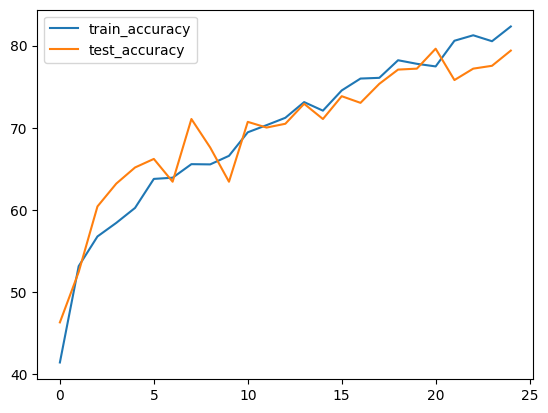

In [ ]:
# Vẽ biểu đồ độ chính xác(accuracy)
plt.plot(train_correct,label="train_accuracy")
plt.plot(test_correct,label="test_accuracy")
plt.legend()

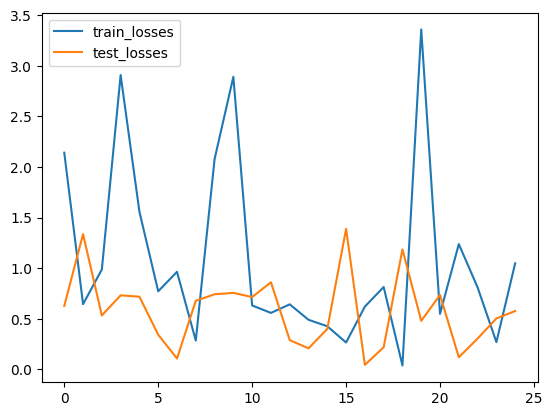

In [ ]:
#  Vẽ đồ thị biểu diễn sự thay đổi của hàm mất mát
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()

#Phân loại

In [ ]:
# Tải lại mô hình đã lưu từ tệp
ResnetModel = Resnet18()
ResnetModel.load_state_dict(torch.load('/content/drive/MyDrive/Thị giác máy tính/CV-project/model/model_resnet18.pth'))
ResnetModel.to(device)
ResnetModel.eval()

Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

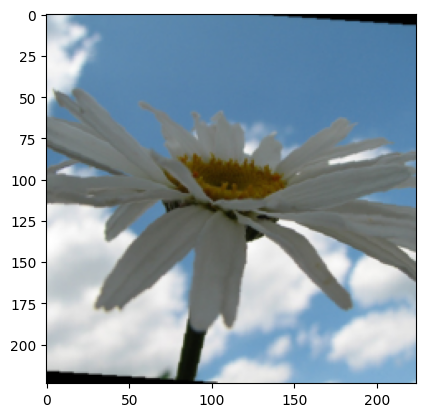

In [ ]:
x=35 #chọn một mẫu cụ thể từ tập dữ liệu
im = inv_normalize(test_data[x][0]) #Truy cập phần tử thứ x và lấy phần đầu tiên của phần tử này(ảnh)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))# đảo ngược quá trình chuẩn hóa ảnh

In [ ]:
test_data[x][0].shape#trả về kích thước của tensor ảnh
# ảnh có 3 kênh màu (RGB), chiều cao 224 pixel, và chiều rộng 224 pixel.

torch.Size([3, 224, 224])

In [ ]:
# Dự đoán cho một trong các mẫu.
ResnetModel.eval()# Đặt mô hình ResnetModel ở chế độ đánh giá (evaluation mode)

with torch.no_grad():#không tính gradient trong quá trình dự đoán, giúp tiết kiệm bộ nhớ và tăng tốc độ tính toán
#Thay đổi kích thước của tensor ảnh thành (1, 3, 224, 224). định dạng mà mô hình: batch size là 1, 3 kênh màu (RGB), và kích thước ảnh 224x224 pixel.
    new_pred=ResnetModel(test_data[x][0].view(1,3,224,224).to(device)).argmax()
#In ra label và tên loài hoa tương ứng
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 daisy
